In [121]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack


Variable initialization

In [122]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [123]:
for i in range(M):
  DCT[:, i] = sp.fftpack.dct(np.eye(M)[:, i], norm='ortho')


Generating the 1-D standard basis

In [124]:
for i in range(M):
    C[:, i] = np.eye(M)[:, i]


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

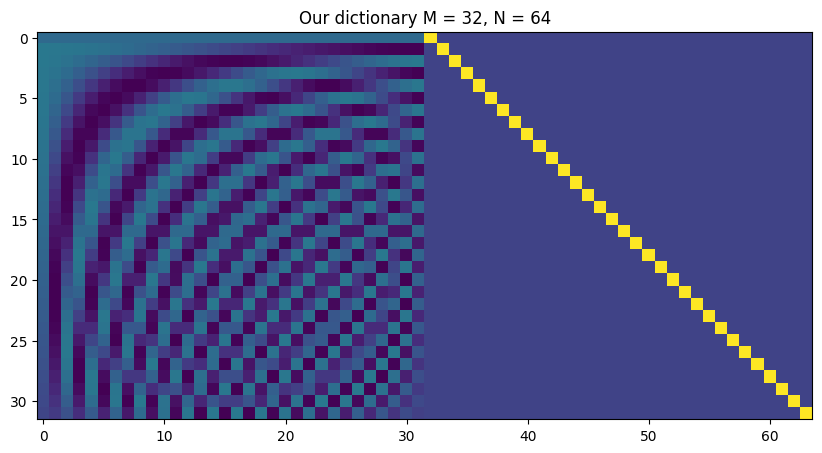

In [125]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [126]:
L = int(0.1*N)
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [127]:
x0 = np.zeros((N, 1))
x0[:L] = np.random.randn(L, 1)
# shuffle the coefficients
np.random.shuffle(x0)

Choose spike location

In [128]:
spikeLocation = np.random.randint(0, N)
x0[spikeLocation] = 10

In [129]:
x0[x0 != 0]

array([ 1.20494882, -0.31202327, -0.39060768, -1.0213582 , 10.        ,
       -0.26462946,  1.00600592])

Synthetize the corresponding signal in the signal domain and add noise


In [130]:
s0 = D @ x0
s = s0 + sigma_noise * np.random.randn(M, 1)

Plot the sparse signal

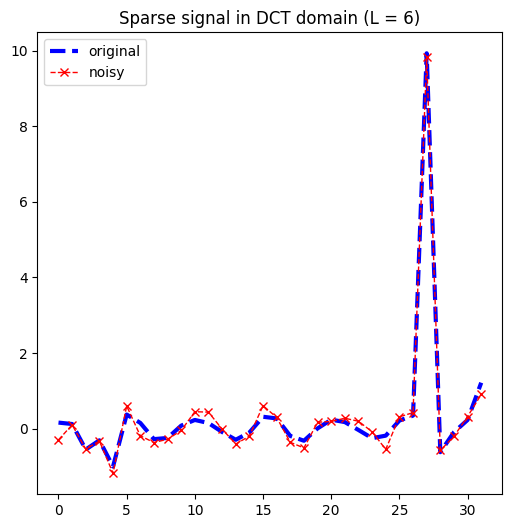

In [131]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [132]:
x_OMP = np.zeros((N, 1))

# residual
r = s.copy()

# support set
omega = []
i=0

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [133]:
while np.linalg.norm(r) > MINIMUM_NORM_RES and len(omega) < L:
    print(f"Iteration {i}")
    # SWEEP STEP
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = (r.T @ dj)**2 / np.linalg.norm(dj)**2

    # find the column of D that matches best r
    jStar = np.argmax(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s||
    D_omega = D[:, omega]
    x_w, _, _, _ = np.linalg.lstsq(D_omega, s, rcond=None)
    for j, w in zip(omega, x_w.flatten()): 
        x_OMP[j] = w

    # update the residual
    r = s - D @ x_OMP
    i += 1

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [134]:
s_hat_OMP = D @ x_OMP

Show the result

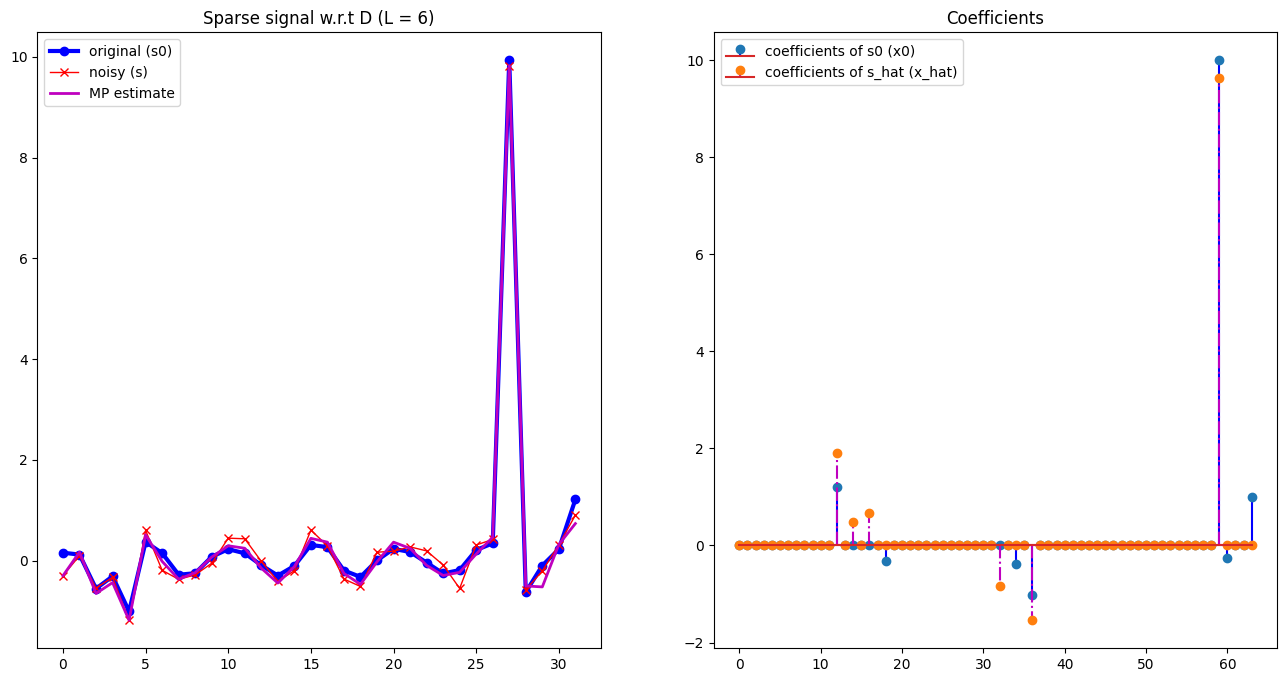

In [135]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [136]:
x_LSOMP = np.zeros((N,1))

# residual
r = s.copy()

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [137]:
cnt = 0
while np.count_nonzero(x_LSOMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:
    cnt +=1
    print(f"I'm at iteration #{cnt}, residual norm: {np.linalg.norm(r)}")
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            dj = D[:, j]
            e[j] = (r.T @ dj)**2 / np.linalg.norm(dj)**2

        # find the column of D that matches best r
        jStar = np.argmax(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)

        # update the coefficients by solving the least square problem min ||D_omega x - s||
        D_jstar = D[:, jStar]
        x_LSOMP[jStar] += (r.T @ D_jstar) / np.linalg.norm(D_jstar)**2
    else:
        # perform the sweep step by solving the LS problem
        e = np.zeros(N)
        for j in range(N):
            if j not in omega:
                dj = D[:, j]
                D_omega = D[:, omega]
                M1 = np.block([[np.dot(D_omega.T, D_omega), np.dot(D_omega.T, dj).reshape(-1, 1)],
                               [np.dot(dj.T, D_omega).reshape(1, -1), np.dot(dj.T, dj).reshape(1, 1)]])
                M1 = np.linalg.pinv(M1)
                M2 = np.vstack([np.dot(D_omega.T,s),np.dot(dj.T,s)])
                omegaj = omega.copy()
                omegaj.append(j)
                e[j] = np.linalg.norm((s - np.dot(D[:, omegaj], np.dot(M1, M2)))**2,2)
            else:
                e[j] = +np.inf
        
        jStar = np.argmin(e)


        # update the coefficients
        D_omega = D[:, omega]
        D_jstar = D[:, jStar]
        
        D_omega_j = np.hstack((D_omega,D_jstar.reshape((-1,1))))
        z = np.linalg.pinv(D_omega_j.T @ D_omega_j) @ (D_omega_j.T @ s)
        
        # UPDATE the support set with the jStar coefficient
        if jStar not in omega:
            omega.append(jStar)
            
        x_LSOMP[omega] = z

    # update the residual
    r = s - D @ x_LSOMP



I'm at iteration #1, residual norm: 10.122851606305785
I'm at iteration #2, residual norm: 2.452123097508565
I'm at iteration #3, residual norm: 2.147885744593373
I'm at iteration #4, residual norm: 1.2523901511911293
I'm at iteration #5, residual norm: 1.0896314707761559
I'm at iteration #6, residual norm: 1.0236303240360696


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [138]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

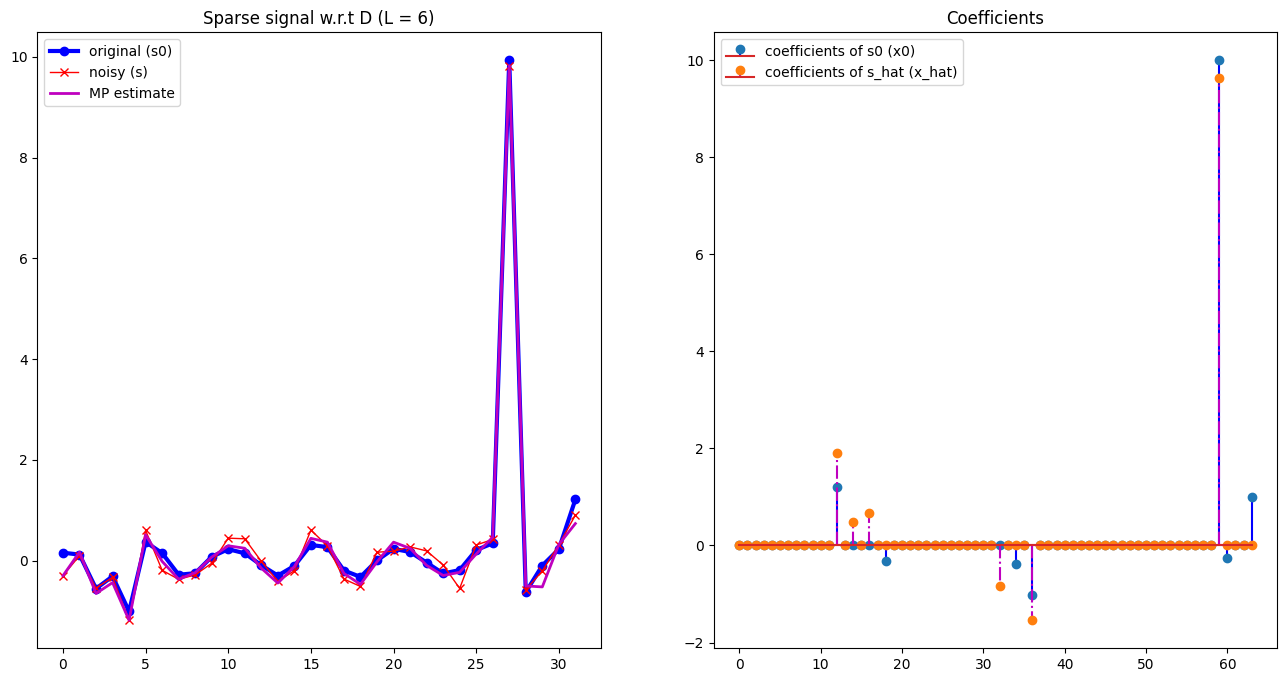

In [139]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])